Följer nedan webbaserad bok kapitel 4.7 för att med  Logistic Regression se om det är möjligt att förutsäga pris på Ethereum (krypto).

https://www.statlearning.com/

Via ett api på CoinGeckos kryptosida har jag laddat ner data från 2018 och framåt. Datat återfinns i csv-filen "sammanslagen_data.csv".

Importerar dom bibliotek som behövs.

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from ISLP.models import (ModelSpec as MS,summarize)

In [7]:
from ISLP import confusion_table
from ISLP.models import contrast
from sklearn.discriminant_analysis import \
(LinearDiscriminantAnalysis as LDA,
QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [58]:
# Sökvägen till CSV-fil
csv_fil_sökväg = "sammanslagen_data.csv"

# Läs in CSV-filen
crypto_data = pd.read_csv(csv_fil_sökväg)

# Visa de första raderna av DataFrame
crypto_data.head(10)


,Date,Price
0,2018-01-01,6345
1,2018-01-02,7155
2,2018-01-03,7879
3,2018-01-04,7959
4,2018-01-05,8199
5,2018-01-06,8583
6,2018-01-07,9267
7,2018-01-08,9723
8,2018-01-09,11216
9,2018-01-10,11023


In [59]:
# Skriv ut antalet rader i DataFrame
print("Antal rader i datasetet:", len(crypto_data))

Antal rader i datasetet: 1825


In [60]:
crypto_data.columns

Index(['Date', 'Price'], dtype='object')

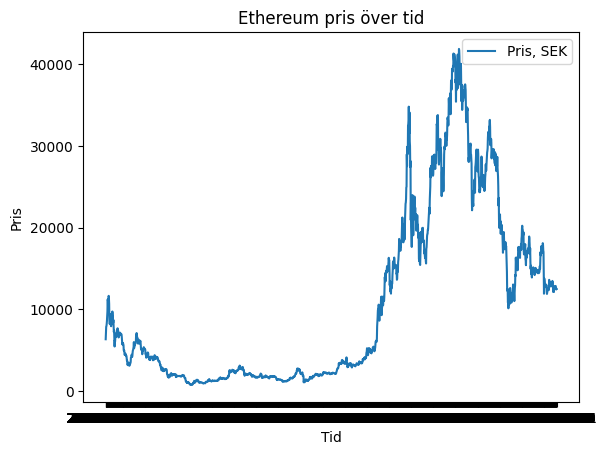

In [61]:
# Plotta datan
plt.plot(crypto_data['Date'], crypto_data['Price'], label='Pris, SEK')
plt.xlabel('Tid')
plt.ylabel('Pris')
plt.title('Ethereum pris över tid')
plt.legend()
plt.show()

### Lägger till LAG1-5 för price och sparar ner som en ny CSV-fil

In [12]:
import pandas as pd

# Skapa en kopia av DataFrame
crypto_price_LAG = crypto_data.copy()

# Skapa laggade värden för Lag1 till Lag5 med shift
for lag in range(1, 6):
    crypto_price_LAG[f'Lag{lag}'] = crypto_price_LAG['Price'].shift(lag)

# Ta bort rader med NaN-värden (eftersom skiftet inte kan beräknas för de första några raderna)
crypto_price_LAG = crypto_price_LAG.dropna()

# Spara DataFrame till en ny CSV-fil
crypto_price_LAG.to_csv('LAG_on_crypto_price_market_subset.csv', index=False)


In [13]:
crypto_price_LAG.columns

Index(['Date', 'Price', 'Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5'], dtype='object')

In [14]:
crypto_price_LAG.head()

,Date,Price,Lag1,Lag2,Lag3,Lag4,Lag5
5,2018-01-06,8583,8199.0,7959.0,7879.0,7155.0,6345.0
6,2018-01-07,9267,8583.0,8199.0,7959.0,7879.0,7155.0
7,2018-01-08,9723,9267.0,8583.0,8199.0,7959.0,7879.0
8,2018-01-09,11216,9723.0,9267.0,8583.0,8199.0,7959.0
9,2018-01-10,11023,11216.0,9723.0,9267.0,8583.0,8199.0


In [15]:
# Skriv ut antalet rader i DataFrame
print("Antal rader i datasetet:", len(crypto_price_LAG))

Antal rader i datasetet: 1820


In [16]:
print(crypto_price_LAG.dtypes)

Date      object
Price      int64
Lag1     float64
Lag2     float64
Lag3     float64
Lag4     float64
Lag5     float64
dtype: object


In [17]:
crypto_price_LAG.corr()

/tmp/ipykernel_19430/2990959623.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  crypto_price_LAG.corr()


,Price,Lag1,Lag2,Lag3,Lag4,Lag5
Price,1.000000,0.997979,0.996210,0.994364,0.992396,0.990308
Lag1,0.997979,1.000000,0.997978,0.996210,0.994362,0.992389
Lag2,0.996210,0.997978,1.000000,0.997978,0.996208,0.994356
Lag3,0.994364,0.996210,0.997978,1.000000,0.997977,0.996203
Lag4,0.992396,0.994362,0.996208,0.997977,1.000000,0.997976
Lag5,0.990308,0.992389,0.994356,0.996203,0.997976,1.000000


/tmp/ipykernel_32473/2425966889.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(crypto_price_LAG.corr(), annot=True, cmap='YlGn', fmt=".2f")


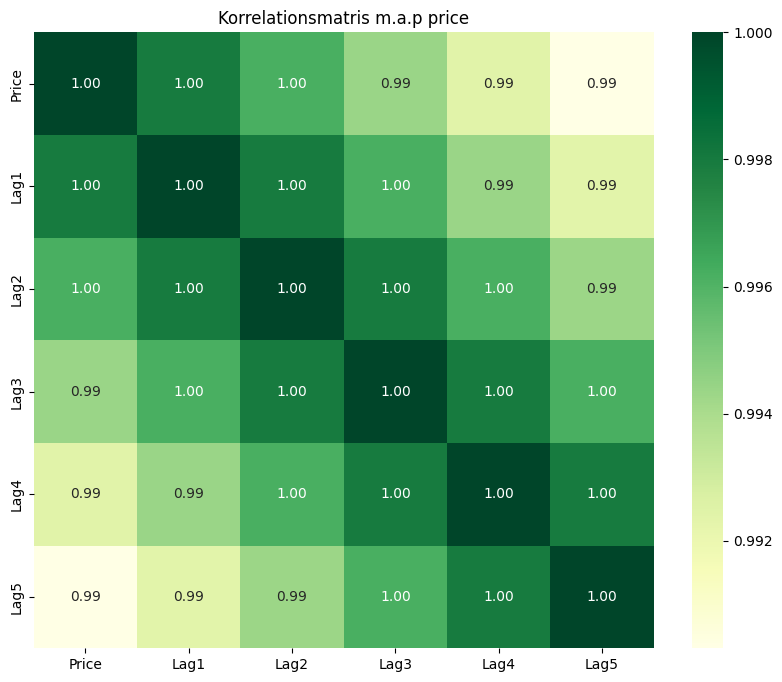

In [96]:
import seaborn as sns
import matplotlib.pyplot as plt

# Skapa en heatmap med korrelationsvärdena
plt.figure(figsize=(10, 8))
sns.heatmap(crypto_price_LAG.corr(), annot=True, cmap='YlGn', fmt=".2f")
plt.title('Korrelationsmatris m.a.p price')
plt.show()


Logistic Regression
Fit a logistic regression model in order to predict Direction using Lag1 through Lag5. The sm.GLM() function fts gener- sm.GLM() alized linear models, a class of models that includes logistic regression. generalized Alternatively, the function linear model sm.Logit() fts a logistic regression model directly. The syntax of sm.GLM() is similar to that of sm.OLS(), except that
we must pass in the argument family=sm.families.Binomial() in order to
tell statsmodels to run a logistic regression rather than some other type of
generalized linear model

Lägger först till en kolumn "Directions" som visar om priset har gått upp eller ner sedan tidigare dag. Sparar ner det nya datasettet i en ny csv.

In [19]:
import pandas as pd

# Läs in datasetet
df_with_direction = pd.read_csv("LAG_on_crypto_price_market_subset.csv")

# Skapa en kolumn "Direction" baserat på prisförändringen jämfört med föregående dag
df_with_direction['Direction'] = df_with_direction['Price'].diff().apply(lambda x: 'Up' if x > 0 else 'Down')

# Spara den uppdaterade datan till en ny CSV-fil
df_with_direction.to_csv("LAG_on_crypto_price_market_subset_with directions.csv", index=False)


In [20]:
df_with_direction.head()

,Date,Price,Lag1,Lag2,Lag3,Lag4,Lag5,Direction
0,2018-01-06,8583,8199.0,7959.0,7879.0,7155.0,6345.0,Down
1,2018-01-07,9267,8583.0,8199.0,7959.0,7879.0,7155.0,Up
2,2018-01-08,9723,9267.0,8583.0,8199.0,7959.0,7879.0,Up
3,2018-01-09,11216,9723.0,9267.0,8583.0,8199.0,7959.0,Up
4,2018-01-10,11023,11216.0,9723.0,9267.0,8583.0,8199.0,Down


In [21]:
print(df_with_direction.dtypes)

Date          object
Price          int64
Lag1         float64
Lag2         float64
Lag3         float64
Lag4         float64
Lag5         float64
Direction     object
dtype: object


#========================================================#
provar att ta med date genom att göra om date från object till int64.

In [2]:
import pandas as pd

# Läs in CSV-filen
df = pd.read_csv('LAG_on_crypto_price_market_subset_with directions.csv')

# Antag att datumkolumnen heter 'Datum'
df['Date'] = pd.to_datetime(df['Date'])

# Konvertera datumkolumnen till Unix-tidsstämplar som int64
df['Date'] = (df['Date'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

# Konvertera datumkolumnen till Unix-tidsstämplar
#df['Date'] = df['Date'].apply(lambda x: int(x.timestamp()))

# Visa DataFrame med Unix-tidsstämplar
print(df)


            Date  Price     Lag1     Lag2     Lag3     Lag4     Lag5 Direction
0     1515196800   8583   8199.0   7959.0   7879.0   7155.0   6345.0      Down
1     1515283200   9267   8583.0   8199.0   7959.0   7879.0   7155.0        Up
2     1515369600   9723   9267.0   8583.0   8199.0   7959.0   7879.0        Up
3     1515456000  11216   9723.0   9267.0   8583.0   8199.0   7959.0        Up
4     1515542400  11023  11216.0   9723.0   9267.0   8583.0   8199.0      Down
...          ...    ...      ...      ...      ...      ...      ...       ...
1815  1672099200  12867  12836.0  12863.0  12857.0  12744.0  12643.0        Up
1816  1672185600  12698  12867.0  12836.0  12863.0  12857.0  12744.0      Down
1817  1672272000  12438  12698.0  12867.0  12836.0  12863.0  12857.0      Down
1818  1672358400  12567  12438.0  12698.0  12867.0  12836.0  12863.0        Up
1819  1672444800  12503  12567.0  12438.0  12698.0  12867.0  12836.0      Down

[1820 rows x 8 columns]


In [3]:
df

,Date,Price,Lag1,Lag2,Lag3,Lag4,Lag5,Direction
0,1515196800,8583,8199.0,7959.0,7879.0,7155.0,6345.0,Down
1,1515283200,9267,8583.0,8199.0,7959.0,7879.0,7155.0,Up
2,1515369600,9723,9267.0,8583.0,8199.0,7959.0,7879.0,Up
3,1515456000,11216,9723.0,9267.0,8583.0,8199.0,7959.0,Up
4,1515542400,11023,11216.0,9723.0,9267.0,8583.0,8199.0,Down
...,...,...,...,...,...,...,...,...
1815,1672099200,12867,12836.0,12863.0,12857.0,12744.0,12643.0,Up
1816,1672185600,12698,12867.0,12836.0,12863.0,12857.0,12744.0,Down
1817,1672272000,12438,12698.0,12867.0,12836.0,12863.0,12857.0,Down
1818,1672358400,12567,12438.0,12698.0,12867.0,12836.0,12863.0,Up


In [56]:
print(df.dtypes)

Date           int64
Price          int64
Lag1         float64
Lag2         float64
Lag3         float64
Lag4         float64
Lag5         float64
Direction     object
dtype: object


df_with_direction=df_with_direction.select_dtypes(include=[np.number]).corr()

In [57]:
df.corr()

/tmp/ipykernel_19430/1134722465.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,Date,Price,Lag1,Lag2,Lag3,Lag4,Lag5
Date,1.000000,0.695731,0.695750,0.695783,0.695832,0.695916,0.696048
Price,0.695731,1.000000,0.997979,0.996210,0.994364,0.992396,0.990308
Lag1,0.695750,0.997979,1.000000,0.997978,0.996210,0.994362,0.992389
Lag2,0.695783,0.996210,0.997978,1.000000,0.997978,0.996208,0.994356
Lag3,0.695832,0.994364,0.996210,0.997978,1.000000,0.997977,0.996203
Lag4,0.695916,0.992396,0.994362,0.996208,0.997977,1.000000,0.997976
Lag5,0.696048,0.990308,0.992389,0.994356,0.996203,0.997976,1.000000


#==========================================================#

In [22]:
df_with_direction.corr()

/tmp/ipykernel_19430/2989462644.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_with_direction.corr()


,Price,Lag1,Lag2,Lag3,Lag4,Lag5
Price,1.000000,0.997979,0.996210,0.994364,0.992396,0.990308
Lag1,0.997979,1.000000,0.997978,0.996210,0.994362,0.992389
Lag2,0.996210,0.997978,1.000000,0.997978,0.996208,0.994356
Lag3,0.994364,0.996210,0.997978,1.000000,0.997977,0.996203
Lag4,0.992396,0.994362,0.996208,0.997977,1.000000,0.997976
Lag5,0.990308,0.992389,0.994356,0.996203,0.997976,1.000000


In [23]:
allvars = df_with_direction.columns.drop(['Date', "Direction"])
print(allvars)
design = MS(allvars)
X = design.fit_transform(df_with_direction)
y = df_with_direction.Direction == 'Up'
glm = sm.GLM(y,
X,
family=sm.families.Binomial())
results = glm.fit()
summarize(results)

Index(['Price', 'Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5'], dtype='object')


/mnt/c/Users/aras/python_iths/iths_2023_sep_dec/aras_venv/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/mnt/c/Users/aras/python_iths/iths_2023_sep_dec/aras_venv/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:1056: RuntimeWarning: divide by zero encountered in log
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu + 1e-20)) +
/mnt/c/Users/aras/python_iths/iths_2023_sep_dec/aras_venv/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:1056: RuntimeWarning: invalid value encountered in multiply
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu + 1e-20)) +


,coef,std err,z,P>|z|
intercept,0.011800,0.199,0.059,0.953
Price,0.175900,0.016,11.027,0.000
Lag1,-0.176100,0.016,-10.994,0.000
Lag2,-0.000400,0.002,-0.237,0.813
Lag3,-0.000400,0.002,-0.244,0.807
Lag4,0.000052,0.002,0.033,0.974
Lag5,0.000800,0.001,0.823,0.411


In [24]:
results.params

intercept    0.011838
Price        0.175929
Lag1        -0.176060
Lag2        -0.000375
Lag3        -0.000383
Lag4         0.000052
Lag5         0.000825
dtype: float64

In [25]:
results.pvalues

intercept    9.526022e-01
Price        2.838449e-28
Lag1         4.066429e-28
Lag2         8.125982e-01
Lag3         8.072500e-01
Lag4         9.735433e-01
Lag5         4.107430e-01
dtype: float64

In [26]:
# Hämta p-värdena
p_values = results.pvalues

# Formatera p-värdena med 4 decimaler
formatted_p_values = p_values.apply(lambda x: "{:.4f}".format(x))

# Visa de formaterade p-värdena
print(formatted_p_values)


intercept    0.9526
Price        0.0000
Lag1         0.0000
Lag2         0.8126
Lag3         0.8072
Lag4         0.9735
Lag5         0.4107
dtype: object


In [27]:
probs = results.predict()
probs[:10]

/mnt/c/Users/aras/python_iths/iths_2023_sep_dec/aras_venv/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


array([1.00000000e+000, 1.00000000e+000, 1.00000000e+000, 1.00000000e+000,
       4.25386626e-016, 1.27925297e-109, 1.00000000e+000, 1.00000000e+000,
       2.36103701e-024, 5.74679199e-053])

In order to make a prediction as to whether the market will go up or
down on a particular day, we must convert these predicted probabilities
into class labels, Up or Down. The following two commands create a vector
of class predictions based on whether the predicted probability of a market
increase is greater than or less than 0.5.

In [28]:
labels = np.array(['Down']*1820)
labels[probs >0.5] = "Up"

The confusion_table() function from the ISLP package summarizes these confusion_
table() predictions, showing how many observations were correctly or incorrectly
classifed. Our function, which is adapted from a similar function in the
module sklearn.metrics, transposes the resulting matrix and includes row
and column labels. The confusion_table() function takes as

In [29]:
from sklearn.metrics import confusion_matrix
confusion_matrix(labels, df.Direction)

array([[888,   1],
       [  5, 926]])

På ovan matrix. Titta på diagonalvärderna. The diagonal elements of the confusion matrix indicate correct predictions. 888 för korrekta down samt 926 för korrekta up. Summa 888+926=1814

In [35]:
(888+926)/1820, np.mean(labels == df_with_direction.Direction)

(0.9967032967032967, 0.9967032967032967)

In [31]:
print(df_with_direction)

            Date  Price     Lag1     Lag2     Lag3     Lag4     Lag5 Direction
0     2018-01-06   8583   8199.0   7959.0   7879.0   7155.0   6345.0      Down
1     2018-01-07   9267   8583.0   8199.0   7959.0   7879.0   7155.0        Up
2     2018-01-08   9723   9267.0   8583.0   8199.0   7959.0   7879.0        Up
3     2018-01-09  11216   9723.0   9267.0   8583.0   8199.0   7959.0        Up
4     2018-01-10  11023  11216.0   9723.0   9267.0   8583.0   8199.0      Down
...          ...    ...      ...      ...      ...      ...      ...       ...
1815  2022-12-27  12867  12836.0  12863.0  12857.0  12744.0  12643.0        Up
1816  2022-12-28  12698  12867.0  12836.0  12863.0  12857.0  12744.0      Down
1817  2022-12-29  12438  12698.0  12867.0  12836.0  12863.0  12857.0      Down
1818  2022-12-30  12567  12438.0  12698.0  12867.0  12836.0  12863.0        Up
1819  2022-12-31  12503  12567.0  12438.0  12698.0  12867.0  12836.0      Down

[1820 rows x 8 columns]


The object train is a vector of 1820 elements, corresponding to the
observations in our data set. The elements of the vector that correspond
to observations that occurred before 2022-11-01 are set to True, whereas those
that correspond to observations after 2022-11-01 are set to False. Hence train is a
boolean array, since its elements are True and False. Boolean arrays can be
used to obtain a subset of the rows or columns of a data frame using the loc method.

In [36]:
train = (df_with_direction.Date < "2022-11-01")
df_train = df_with_direction.loc[train]
df_test = df_with_direction.loc[~train]
df_test.shape

(61, 8)

In [37]:
print(train)

0        True
1        True
2        True
3        True
4        True
        ...  
1815    False
1816    False
1817    False
1818    False
1819    False
Name: Date, Length: 1820, dtype: bool


In [38]:
print(df_train)

            Date  Price     Lag1     Lag2     Lag3     Lag4     Lag5 Direction
0     2018-01-06   8583   8199.0   7959.0   7879.0   7155.0   6345.0      Down
1     2018-01-07   9267   8583.0   8199.0   7959.0   7879.0   7155.0        Up
2     2018-01-08   9723   9267.0   8583.0   8199.0   7959.0   7879.0        Up
3     2018-01-09  11216   9723.0   9267.0   8583.0   8199.0   7959.0        Up
4     2018-01-10  11023  11216.0   9723.0   9267.0   8583.0   8199.0      Down
...          ...    ...      ...      ...      ...      ...      ...       ...
1754  2022-10-27  17013  16043.0  14972.0  15285.0  14699.0  14534.0        Up
1755  2022-10-28  16599  17013.0  16043.0  14972.0  15285.0  14699.0      Down
1756  2022-10-29  17024  16599.0  17013.0  16043.0  14972.0  15285.0        Up
1757  2022-10-30  17729  17024.0  16599.0  17013.0  16043.0  14972.0        Up
1758  2022-10-31  17459  17729.0  17024.0  16599.0  17013.0  16043.0      Down

[1759 rows x 8 columns]


In [39]:
print(df_test)

            Date  Price     Lag1     Lag2     Lag3     Lag4     Lag5 Direction
1759  2022-11-01  17357  17459.0  17729.0  17024.0  16599.0  17013.0      Down
1760  2022-11-02  17417  17357.0  17459.0  17729.0  17024.0  16599.0        Up
1761  2022-11-03  16907  17417.0  17357.0  17459.0  17729.0  17024.0      Down
1762  2022-11-04  17138  16907.0  17417.0  17357.0  17459.0  17729.0        Up
1763  2022-11-05  18099  17138.0  16907.0  17417.0  17357.0  17459.0        Up
...          ...    ...      ...      ...      ...      ...      ...       ...
1815  2022-12-27  12867  12836.0  12863.0  12857.0  12744.0  12643.0        Up
1816  2022-12-28  12698  12867.0  12836.0  12863.0  12857.0  12744.0      Down
1817  2022-12-29  12438  12698.0  12867.0  12836.0  12863.0  12857.0      Down
1818  2022-12-30  12567  12438.0  12698.0  12867.0  12836.0  12863.0        Up
1819  2022-12-31  12503  12567.0  12438.0  12698.0  12867.0  12836.0      Down

[61 rows x 8 columns]


We now ft a logistic regression model using only the subset of the observations that correspond to dates before 2022-11-01. We then obtain predicted
probabilities of the stock market going up for each of the days in our test
set — that is, for the days before 2022-11-01.

In [40]:
X_train, X_test = X.loc[train], X.loc[~train]
y_train, y_test = y.loc[train], y.loc[~train]
glm_train = sm.GLM(y_train,
X_train,
family=sm.families.Binomial())
results = glm_train.fit()
probs = results.predict(exog=X_test)

/mnt/c/Users/aras/python_iths/iths_2023_sep_dec/aras_venv/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Finally, we compare the predictions for dates after 2022-11-01 to the actual movements of
the market over that time period. We will frst store the test and training
labels (recall y_test is binary).

In [41]:
D = df_with_direction.Direction
L_train, L_test = D.loc[train], D.loc[~train]

In [42]:
print(D)

0       Down
1         Up
2         Up
3         Up
4       Down
        ... 
1815      Up
1816    Down
1817    Down
1818      Up
1819    Down
Name: Direction, Length: 1820, dtype: object


In [49]:
labels = np.array(['Down']*61)
labels[probs >0.5] = 'Up'
confusion_table(labels, L_test)

Truth,Down,Up
Predicted,,
Down,34,0
Up,0,27


In [44]:
np.mean(labels == L_test), np.mean(labels != L_test)

(1.0, 0.0)